In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [3]:
try:
    from going_modular import data_setup, engine
except:
    print("downloading...")
    print()
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular.
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

    print("done")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def set_seeds(seed: int = 42):
    """sets random sets for torch operation
    
    Args:
         seed (int, optional) : Random seed to set. default 42."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
import os
import zipfile
from pathlib import Path
import requests


# our source: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """download a zipped file from the source and unzips it to the destination."""
    # setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # if the image folder doesn't exist, create it
    if image_path.is_dir():
        print(f"[info] {image_path} directory already exit, skipping download.")
    else:
        print(f"[info] did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # download the target data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[info] downloading {target_file} from {source} ...")
            f.write(request.content)

        # unzipping
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[info] Unzipping {target_file} data ...")
            zip_ref.extractall(image_path)

        # removing source
        if remove_source:
            os.remove(data_path / target_file)
    return image_path


image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
    remove_source=True)
image_path

[info] data\pizza_steak_sushi directory already exit, skipping download.


WindowsPath('data/pizza_steak_sushi')

### create DataLoader with manual transform

In [7]:
## create DataLoader with manual transform
# setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [8]:
# setup imagenet normalization

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# create transforms pipeline manually
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])
print(manual_transforms)
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               test_transform=manual_transforms,
                                                                               batch_size=32,
                                                                               num_workers=0)
train_dataloader, test_dataloader, class_names

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x21fdf556810>,
 ['pizza', 'steak', 'sushi'])

### automaticlly method 

In [9]:
train_dir = image_path/"train"
test_dir = image_path/"test"
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # means best available
automatic_transforms = weights.transforms()
print(automatic_transforms)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               test_transform=automatic_transforms,
                                                                               batch_size=32,
                                                                               num_workers=0)
train_dataloader, test_dataloader, class_names

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x21fdf65ce10>,
 ['pizza', 'steak', 'sushi'])

### getting pretrained model

In [10]:
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) OLD
torch.hub.set_dir("data")
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# freeze all base layers by setting required_grad to false.
for param in model.parameters():
    param.requires_grad = False

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
# adjust classifier
set_seeds()
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(in_features=1280, out_features=3, bias=True)).to(device)

In [14]:
from torchinfo import summary
summary(model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        verbose=0)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [17]:
# set up a summery writer
# import tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [18]:
from going_modular.engine import train_step, test_step
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### new ###
        writer.add_scalars(main_tag="Loss",
                          tag_scalar_dict={"Train_loss":train_loss,
                                            "Test_Loss":test_loss},
                          global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"Train_accuracy": train_acc,
                                            "Test_accuracy": test_acc},
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    writer.close()

    # Return the filled results at the end of the epochs
    return results

In [19]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0916 | train_acc: 0.3828 | test_loss: 0.9098 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.8992 | train_acc: 0.6445 | test_loss: 0.7881 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8069 | train_acc: 0.7422 | test_loss: 0.6774 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6824 | train_acc: 0.8555 | test_loss: 0.6742 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7078 | train_acc: 0.7227 | test_loss: 0.6794 | test_acc: 0.7737


# tensorboard view

In [20]:
# %load_ext tensorboard
# %tensorboard --logdir runs

one experiment = one folder
* Experiment data/timestamp
* Experiment name
* Model name
* Extra - anything else that should be tracked

`run/YYYY-MM-DD/experiment_name/model_name/extra`

In [53]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    """Creates troch.utils.tensorboard.writer.summarywriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os
    # get timestamp of current date in reverse order : YYYY_MM_DD | datetime.now().strftime("%Y-%m-%d-%H-%M-%S") |
    timestamp = datetime.now().strftime("%Y-%m-%d-%H")

    # create log directory path
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] create SummaryWriter sving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [35]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="efficientb0",
                              extra="5_epochs")
example_writer

[INFO] create SummaryWriter sving to runs\2023-11-14-16\data_10_percent\efficientb0\5_epochs


In [57]:
from going_modular.engine import train_step, test_step
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if writer:
        ### new ###
          writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"Train_loss":train_loss,
                                              "Test_Loss":test_loss},
                            global_step=epoch)
          writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict={"Train_accuracy": train_acc,
                                              "Test_accuracy": test_acc},
                            global_step=epoch)
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    writer.close()

    # Return the filled results at the end of the epochs
    return results

Experimen Trackimg:
* change the number of epochs
* change the number of hidden layers/units
* Change the amount of data (right now we are using 10% of the Food101 dataset for pizza,steak,sushi)
* Changimg the learning rate
* Try diffrent kind of data augmentation
* Choose a different model architecture

# Now:
* model_size -> efficientb0 vs efficientb2
* dataset_size -> 10% vs 20%
* training time -> 5 epochs vs 10 epochs

In [36]:
# download data
data_10_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                destination="pizza_steak_sushi")
data_20_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                destination="pizza_steak_sushi_20_percent")


[info] data\pizza_steak_sushi directory already exit, skipping download.
[info] did not find data\pizza_steak_sushi_20_percent directory, creating one...
[info] downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip ...
[info] Unzipping pizza_steak_sushi_20_percent.zip data ...


# create dataloader
* resize images
* make sure image tensor values are between 0, 1
* normalize images

In [37]:
# setup path
train_dir_10_percent = data_10_percent / "train"
train_dir_20_percent = data_20_percent / "train"

# setup test directory
test_dir = data_10_percent / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [38]:
from torchvision import transforms
normilize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
simple_transforms = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize])
                                        

In [40]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          test_transform = simple_transforms,
                                                                                          batch_size = BATCH_SIZE,
                                                                                          num_workers=0)
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          test_transform = simple_transforms,
                                                                                          batch_size = BATCH_SIZE,
                                                                                          num_workers=0)

print(f"Number of batches of size {BATCH_SIZE} in 10% training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% testing data: {len(test_dataloader)}")
print(f"class names: {class_names}")


Number of batches of size 32 in 10% training data: 8
Number of batches of size 32 in 20% training data: 15
Number of batches of size 32 in 10% testing data: 3
class names: ['pizza', 'steak', 'sushi']


In [41]:
from torchvision import models
model1 = models.efficientnet_b0(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False
model1.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(in_features=1280, out_features=3))

c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to data\checkpoints\efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:22<00:00, 1.66MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [43]:
summary(model=effnetb2,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [46]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = "effnetb0"
    print(f"[INFO] create new {model.name} model")
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = "effnetb2"
    print(f"[INFO] create new {model.name} model")
    return model


In [47]:
created_model_test_effnetb0 = create_effnetb0()
created_model_test_effnetb2 = create_effnetb2()

c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] create new effnetb0 model


c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] create new effnetb2 model


In [49]:
summary(model=created_model_test_effnetb2,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [50]:
# epochs
num_epochs = [5,10]
models = ["effnetb0", "effnetb2"]
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [59]:
%%time
from going_modular.utils import save_model
set_seeds()

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            print(f"[INFO] experiment number: {experiment_number}")
            print(f"[INFO] model: {model_name}")
            print(f"[INFO] dataloader: {dataloader_name}")
            print(f"[INFO] epochs: {epochs}")
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)
            train(model=model,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader,
                  optimizer= optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            save_file_path = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,target_dir="models", model_name=save_file_path)
            
            print("_"*50 + "\n")

[INFO] experiment number: 0
[INFO] model: effnetb0
[INFO] dataloader: data_10_percent
[INFO] epochs: 5
[INFO] create new effnetb0 model
[INFO] create SummaryWriter sving to runs\2023-11-14-19\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0391 | train_acc: 0.5078 | test_loss: 0.9272 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.5469 | test_loss: 0.8404 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8205 | train_acc: 0.6875 | test_loss: 0.7328 | test_acc: 0.7945
Epoch: 4 | train_loss: 0.7125 | train_acc: 0.7500 | test_loss: 0.6229 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6172 | train_acc: 0.8945 | test_loss: 0.5898 | test_acc: 0.8456
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] experiment number: 0
[INFO] model: effnetb2
[INFO] dataloader: data_10_percent
[INFO] epochs: 5


c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] create new effnetb2 model
[INFO] create SummaryWriter sving to runs\2023-11-14-19\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0934 | train_acc: 0.3828 | test_loss: 0.9619 | test_acc: 0.6705
Epoch: 2 | train_loss: 0.8968 | train_acc: 0.6250 | test_loss: 0.9052 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8437 | train_acc: 0.6797 | test_loss: 0.8062 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7015 | train_acc: 0.8711 | test_loss: 0.6942 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7086 | train_acc: 0.7344 | test_loss: 0.6527 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] experiment number: 0
[INFO] model: effnetb0
[INFO] dataloader: data_10_percent
[INFO] epochs: 10
[INFO] create new effnetb0 model
[INFO] create SummaryWriter sving to runs\2023-11-14-19\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0391 | train_acc: 0.5078 | test_loss: 0.9272 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.5469 | test_loss: 0.8404 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8205 | train_acc: 0.6875 | test_loss: 0.7328 | test_acc: 0.7945
Epoch: 4 | train_loss: 0.7125 | train_acc: 0.7500 | test_loss: 0.6229 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6172 | train_acc: 0.8945 | test_loss: 0.5898 | test_acc: 0.8456
Epoch: 6 | train_loss: 0.5510 | train_acc: 0.8555 | test_loss: 0.6000 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6406 | train_acc: 0.7344 | test_loss: 0.6012 | test_acc: 0.8258
Epoch: 8 | train_loss: 0.5125 | train_acc: 0.7930 | test_loss: 0.5450 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4634 | train_acc: 0.9219 | test_loss: 0.5351 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5806 | train_acc: 0.7539 | test_loss: 0.4900 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
____________________________________

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0934 | train_acc: 0.3828 | test_loss: 0.9619 | test_acc: 0.6705
Epoch: 2 | train_loss: 0.8968 | train_acc: 0.6250 | test_loss: 0.9052 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8437 | train_acc: 0.6797 | test_loss: 0.8062 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7015 | train_acc: 0.8711 | test_loss: 0.6942 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7086 | train_acc: 0.7344 | test_loss: 0.6527 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5900 | train_acc: 0.9023 | test_loss: 0.6611 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6138 | train_acc: 0.8242 | test_loss: 0.6075 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5404 | train_acc: 0.8164 | test_loss: 0.6054 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5094 | train_acc: 0.9062 | test_loss: 0.5624 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.5280 | train_acc: 0.8047 | test_loss: 0.5463 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
____________________________________

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9622 | train_acc: 0.6167 | test_loss: 0.6676 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6975 | train_acc: 0.7771 | test_loss: 0.5788 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5819 | train_acc: 0.8396 | test_loss: 0.5017 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.4614 | train_acc: 0.9000 | test_loss: 0.4201 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4572 | train_acc: 0.8542 | test_loss: 0.3886 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] experiment number: 0
[INFO] model: effnetb2
[INFO] dataloader: data_20_percent
[INFO] epochs: 5
[INFO] create new effnetb2 model
[INFO] create SummaryWriter sving to runs\2023-11-14-19\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9909 | train_acc: 0.5292 | test_loss: 0.7928 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7116 | train_acc: 0.7917 | test_loss: 0.6622 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8771 | test_loss: 0.5622 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5323 | train_acc: 0.8542 | test_loss: 0.5181 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4658 | train_acc: 0.8625 | test_loss: 0.4509 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] experiment number: 0
[INFO] model: effnetb0
[INFO] dataloader: data_20_percent
[INFO] epochs: 10
[INFO] create new effnetb0 model
[INFO] create SummaryWriter sving to runs\2023-11-14-19\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9622 | train_acc: 0.6167 | test_loss: 0.6676 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6975 | train_acc: 0.7771 | test_loss: 0.5788 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5819 | train_acc: 0.8396 | test_loss: 0.5017 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.4614 | train_acc: 0.9000 | test_loss: 0.4201 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4572 | train_acc: 0.8542 | test_loss: 0.3886 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4116 | train_acc: 0.8938 | test_loss: 0.3738 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3972 | train_acc: 0.8583 | test_loss: 0.3409 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3478 | train_acc: 0.8917 | test_loss: 0.3494 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3714 | train_acc: 0.9000 | test_loss: 0.3487 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3768 | train_acc: 0.8896 | test_loss: 0.2870 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
____________________________________

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9909 | train_acc: 0.5292 | test_loss: 0.7928 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7116 | train_acc: 0.7917 | test_loss: 0.6622 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8771 | test_loss: 0.5622 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5323 | train_acc: 0.8542 | test_loss: 0.5181 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4658 | train_acc: 0.8625 | test_loss: 0.4509 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3884 | train_acc: 0.9083 | test_loss: 0.4606 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3691 | train_acc: 0.8854 | test_loss: 0.4231 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3418 | train_acc: 0.8938 | test_loss: 0.4221 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3561 | train_acc: 0.8854 | test_loss: 0.4433 | test_acc: 0.8371
Epoch: 10 | train_loss: 0.3763 | train_acc: 0.8604 | test_loss: 0.3793 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
____________________________________

### The best model is : effnetb2/5 epochs/20% data

In [63]:
# Upload it
# !tensorboard dev upload --logdir runs \
#     --name "first_try" \
#     --description "comparing results of different model size."
#     --one_shot
#doesn't work for me!!!

In [64]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"
# load it
best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

c:\All Python Projects\Interpreters\in_Machine_Learning_GPU117\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] create new effnetb2 model


<All keys matched successfully>

In [66]:
# check the model file size
from pathlib import Path
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"effnetb2 model size is {effnetb2_model_size} MB")

effnetb2 model size is 29 MB


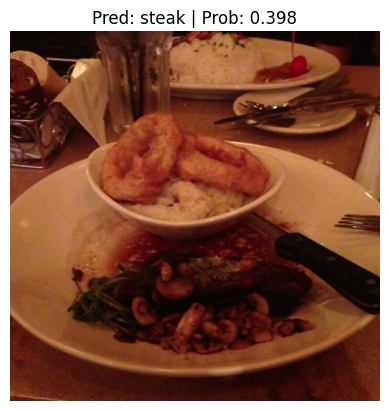

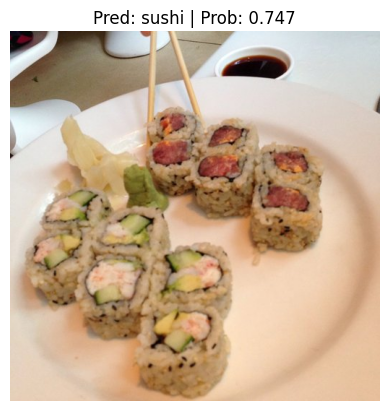

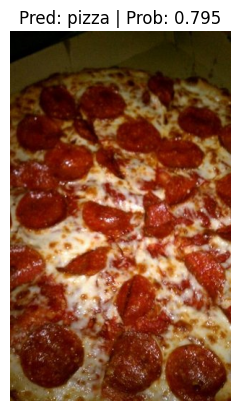

In [70]:
from numpy import imag
from going_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))